# Calibrating Stochastic Processes using Bayesian Inference & Probabilistic Programming

Stochastic processes are used extensively throughout quantitative finance - for example, to simulate asset prices in risk models that aim to estimate key risk metrics such as Value-at-Risk (VaR), Expected Shortfall (ES) and Potential Future Exposure (PFE). Estimating the parameters of a stochastic processes - referred to as 'calibration' in the parlance of quantitative finance -usually involves:

- computing the distribution of price returns for a financial asset;
- deriving point-estimates for the mean and volatility of the returns; and then,
- solving a set of simultaneous equations.

An excellent and accessible account of these statistical procedures for a variety of commonly used stochastic processes is given in ['A Stochastic Processes Toolkit for Risk Management', by Damiano Brigo *et al.*](https://arxiv.org/abs/0812.4210).

The parameter estimates are usually equivalent to Maximum Likelihood (ML) point estimates and often no effort is made to directly quantify the estimation uncertainty and incorporate it into the derived risk metrics, as it involves additional financial engineering that is burdensome. Instead, parameter estimates are usually adjusted heuristically until the results of 'back-testing' risk metrics on historical data become 'acceptable'. 

The purpose of this Python notebook is to demonstrate how Bayesian Inference and Probabilistic Programming (using [PYMC3](https://docs.pymc.io)), is an alternative and more powerful approach that can be viewed as a unified framework for:

- exploiting any available prior knowledge on market prices (quantitative or qualitative);
- estimating the parameters of a stochastic process; and,
- naturally incorporating parameter uncertainty into risk metrics. 

By simulating a Geometric Brownian Motion (GBM) and then estimating the parameters based on the randomly generated observations, we will quantify the impact of using Bayesian Inference against traditional ML estimation, when the available data is both plentiful and scarce - the latter being a scenario in which Bayesian Inference is shown to be especially powerful.

## Imports and Global Settings

Before we get going in earnest, we follow the convention of declaring all imports at the top of the notebook.

In [1]:
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

And then notebook-wide (global) settings that enable in-line plotting, configure Seaborn for visualisation and to explicitly ignore warnings (e.g. NumPy deprecations).

In [2]:
%matplotlib inline

sns.set()
warnings.filterwarnings('ignore')

## Synthetic Data Generation using Geometric Brownian Motion

We start by defining a function for simulating a single path from a GBM - perhaps the most commonly used stochastic process for modelling the time-series of asset prices. We make use of the [following equation](https://en.wikipedia.org/wiki/Geometric_Brownian_motion):

$$
\tilde{S_t} = S_0 \exp \left\{ \left(\mu - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W_t}\right\}
$$

where:

- $t$ is the time in years;
- $S_0$ is value of time-series at the start;
- $\tilde{S_t}$ is value of time-series at time $t$;
- $\mu$ is the annualised drift (or expected return);
- $\sigma$ is the annualised standard deviation of the returns; and,
- $\tilde{W_t}$ is a Brownian motion.

This is the solution to the following stochastic differential equation,

$$
d\tilde{S_t} = \mu \tilde{S_t} dt + \sigma \tilde{S_t} d\tilde{W_t}
$$

For a more in-depth discussion refer to ['A Stochastic Processes Toolkit for Risk Management', by Damiano Brigo *et al.*](https://arxiv.org/abs/0812.4210).

In [3]:
def gbm(start: float, mu: float, sigma: float, days: int) -> np.ndarray:
    """Generate a time-series using a Geometric Brownian Motion (GBM).

    Yields daily values for the specified number of days.

    :parameter start: The starting value.
    :type start: float
    :parameter mu: Anualised drift.
    :type: float
    :parameter sigma: Annualised volatility.
    :type: float
    :parameter days: The number of days to simulate.
    :type: int
    :return: A time-series of values.
    :rtype: np.ndarray
    """

    dt = 1 / 365
    t = np.hstack([np.zeros(1), np.repeat(dt, days-1)]).cumsum()

    dw = np.random.normal(loc=0, scale=np.sqrt(dt), size=days-1)
    w = np.hstack([np.zeros(1), dw]).cumsum()

    s_t = start * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * w)
    return s_t


We now choose _ex ante_ parameter values for an example GBM time-series that we will then estimate using both maximum likelihood and Bayesian Inference.

In [4]:
mu = 0.0
sigma = 0.15

These are 'reasonable' parameter choices for a liquid stock in a 'flat' market - i.e. 0% drift and 15% expected volatility on an annualised basis (the equivalent volatility on a daily basis is ~0.8%). We then take a look at a single simulated time-series over the course of a single year, which we define as 365 days (i.e. ignoring the existence of weekends, bank holidays for the sake of simplicity).

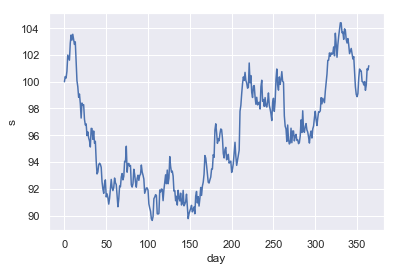

In [5]:
np.random.seed(42)

example_data = pd.DataFrame({
    'day': np.arange(365),
    's': gbm(100, mu, sigma, 365)})

_ = sns.lineplot(x='day', y='s', data=example_data)

## The Traditional Approach to Parameter Estimation

Traditionally, the parameters are estimated using the empirical mean and standard deviation of the daily logarithmic (or geometric) returns. The reasoning behind this can be seen by re-arranging the above equation for $\tilde{S_t}$ as follows,

$$
\log \left( \frac{S_t}{S_{t-1}} \right) = \left(\mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \tilde{\Delta W_t}
$$

Which implies that,

$$
\log \left( \frac{S_t}{S_{t-1}} \right) \sim \text{Normal} \left[ \left(\mu - \frac{\sigma^2}{2} \right) \Delta t, \frac{\sigma^2}{365} \right]
$$

From which it is possible to solve the implied simultaneous equations for $\mu$ and $\sigma$, as functions of the mean and standard deviation of the geometric (i.e. logarithmic) returns. Once again, for a more in-depth discussion we refer the reader to ['A Stochastic Processes Toolkit for Risk Management', by Damiano Brigo *et al.*](https://arxiv.org/abs/0812.4210).

### Parameter Estimation when Data is Plentiful

An example computation, using the whole time-series generated above (364 observations of daily returns), is shown below. We start by taking a look at the distribution of daily returns.

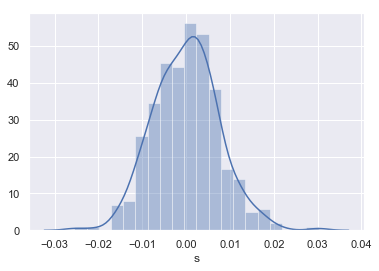

In [6]:
returns_geo_full = (
    np.log(example_data.s)
    .diff(1)
    .dropna())

_ = sns.distplot(returns_geo_full)

The empirical distribution is relatively Normal in appearance, as expected. We now compute $\mu$ and $\sigma$ using the mean and standard deviation (or volatility) of this distribution.

In [7]:
dist_mean_full = returns_geo_full.mean()
dist_vol_full = returns_geo_full.std()

sigma_ml_full = dist_vol_full * np.sqrt(365)
mu_ml_full = dist_mean_full / 365 + 0.5 * sigma_ml_full ** 2

print(f'empirical estimate of mu = {mu_ml_full:.4f}')
print(f'empirical estimate of sigma = {sigma_ml_full:.4f}')

empirical estimate of mu = 0.0101
empirical estimate of sigma = 0.1423


We can see that the empirical estimate of $\sigma$ is close to the _ex ante_ paramter value we chose, but that the estimate of $\mu$ is poor - estimating the drift of a stochastic process is notoriously hard.

### Parameter Estimation when Data is Scarce

Very often data is scare - we may not have 364 observations of geometric returns. To demonstrate the impact this can have on parameter estimation, we sub-sample the distribution of geometric returns by picking 12 returns by random - e.g. to simulate the impact of having only 12 monthly returns to base the estimation on.

In [8]:
n_observations = 12

We now take a look at the distribution of returns.

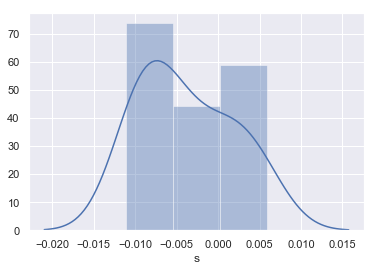

In [9]:
returns_geo = returns_geo_full.sample(n_observations, random_state=42)

_ = sns.distplot(returns_geo, bins=3)

And the corresponding empirical parameter estimates.

In [10]:
dist_mean_ml = returns_geo.mean()
dist_vol_ml = returns_geo.std()

sigma_ml = dist_vol_ml * np.sqrt(365)
mu_ml = dist_mean_ml / 365 + 0.5 * sigma_ml ** 2

print(f'empirical estimate of mu = {mu_ml:.4f}')
print(f'empirical estimate of sigma = {sigma_ml:.4f}')

empirical estimate of mu = 0.0058
empirical estimate of sigma = 0.1080


We can clearly see that now estimates of **both** $\mu$ and $\sigma$ are poor - especially that for $\sigma$, which will likely lead to an underestimation of risk.

## Parameter Estimation using Bayesian Inference and Probabilistic Programming

Like statistical data analysis more broadly, the main aim of Bayesian Data Analysis (BDA) is to infer unknown parameters for models of observed data, in order to test hypotheses about the physical processes that lead to the observations. Bayesian data analysis deviates from traditional statistics - on a practical level - when it comes to the explicit assimilation of prior knowledge regarding the uncertainty of the model parameters, into the statistical inference process and overall analysis workflow. To this end, BDA focuses on the posterior distribution,

$$
p(\Theta | X) = \frac{p(X | \Theta) \cdot p(\Theta)}{p(X)}
$$

Where,

- $\Theta$ is the vector of unknown model parameters, that we wish to estimate; 
- $X$ is the vector of observed data;
- $p(X | \Theta)$ is the likelihood function that models the probability of observing the data for a fixed choice of parameters; and,
- $p(\Theta)$ is the prior distribution of the model parameters.

For an **excellent** (inspirational) introduction to practical BDA, take a look at [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/), or for a more theoretical treatment try [Bayesian Data Analysis by Gelman & co.](http://www.stat.columbia.edu/~gelman/book/).

### Selecting Suitable Prior Distributions

We will choose regularising priors that are also in-line with our prior knowledge of the time-series - that is, priors that place the bulk of their probability mass near zero, but allow for enough variation to make 'reasonable' parameter values viable for our liquid stock in a 'flat' (or drift-less) market.

Note, that in the discussion that follows, we will reason about the priors in terms of our real-world experience of daily price returns, their expected returns and volatility - i.e. the mean and standard deviation of our likelihood function.

#### Choosing a Prior Distribution for the Expected Return of Daily Returns

We choose a Normal distribution for this prior distribution, centered at 0 (i.e. regularising), but with a standard deviation of 0.0001 (i.e. 1 basis-point or 0.01%), to render a 3-4% annualised return a less than 1% probability - consistent with a market for a liquid stock trading 'flat'.

In [11]:
prior_mean_mu = 0
prior_mean_sigma = 0.0001

prior_mean = pm.Normal.dist(mu=prior_mean_mu, sd=prior_mean_sigma)

Plotting the prior distribution for the mean return of daily returns.

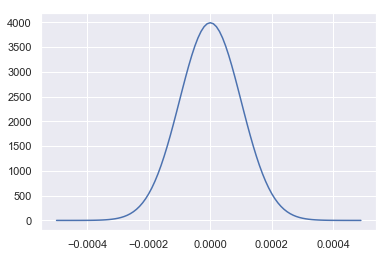

In [12]:
prior_mean_x = np.arange(-0.0005, 0.0005, 0.00001)
prior_mean_density = [np.exp(prior_mean.logp(x).eval())
                    for x in prior_mean_x]

_ = sns.lineplot(x=prior_mean_x, y=prior_mean_density)

#### Choosing a Prior Distribution for the Volatility of Daily Returns

We choose a positive [Half-Normal distribution](https://en.wikipedia.org/wiki/Half-normal_distribution) for this prior distribution. Most of the mass is near 0 (i.e. regularising), but with a standard deviation of 0.0188 that corresponds to an expected daily volatility of ~0.015 (or 1.5%).

In [13]:
prior_vol_sigma = 0.0188

prior_vol = pm.HalfNormal.dist(sd=prior_vol_sigma)

Plotting the prior distribution for volatility of daily returns.

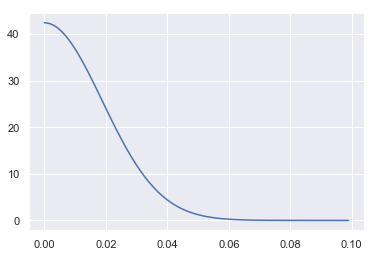

In [14]:
prior_vol_x = np.arange(0, 0.1, 0.001)
prior_vol_density = [np.exp(prior_vol.logp(x).eval())
                       for x in prior_vol_x]

_ = sns.lineplot(x=prior_vol_x, y=prior_vol_density)

### Inference using a Probabilistic Program & Markov Chain Monte Carlo (MCMC)

Performing Bayesian inference usually requires some form of Probabilistic Programming Language (PPL), unless analytical approaches (e.g. based on conjugate prior models), are appropriate for the task at hand. More often than not, PPLs such as [PYMC3](https://docs.pymc.io) implement Markov Chain Monte Carlo (MCMC) algorithms that allow one to draw samples and make inferences from the posterior distribution implied by the choice of model - the likelihood and prior distributions for its parameters - conditional on the observed data.

We will make use of the default MCMC method in PYMC3's `sample` function, which is Hamiltonian Monte Carlo (HMC). Those interested in the precise details of the HMC algorithm are directed to the [excellent paper Michael Betancourt](https://arxiv.org/abs/1701.02434). Briefly, MCMC algorithms work by defining multi-dimensional Markovian stochastic processes, that when simulated (using Monte Carlo methods), will eventually converge to a state where successive simulations will be equivalent to drawing random samples from the posterior distribution of the model we wish to estimate.

The posterior distribution has one dimension for each model parameter, so we can then use the distribution of samples for each parameter to infer the range of possible values and/or compute point estimates (e.g. by taking the mean of all samples).

We start by defining the model we wish to infer - i.e. the probabilistic program.

In [15]:
model_gbm = pm.Model()

with model_gbm:
    prior_mean = pm.Normal('mean', mu=prior_mean_mu, sd=prior_mean_sigma)
    prior_vol = pm.HalfNormal('volatility', sd=prior_vol_sigma)
    
    likelihood = pm.Normal(
        'daily_returns', mu=prior_mean, sd=prior_vol, observed=returns_geo)

In the canoncial format adopted by Bayesian data analysts, this is expressed mathematically as,

In [16]:
model_gbm

We now proceed to perform the inference step. For out purposes, we sample two chains in parallel (as we have two CPU cores available for doing so and this effectively doubles the number of samples), allow 5,000 steps for each chain to converge to its steady-state and then sample for a further 10,000 steps - i.e. generate 20,000 samples from the posterior distribution, assuming that each chain has converged after 5,000 samples.

In [17]:
with model_gbm:
    trace = pm.sample(draws=10000, tune=5000, njobs=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [volatility, mean]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:29<00:00, 1010.15draws/s]


We then take a look at the marginal parameter distributions inferred by each chain, together with the corresponding trace plots - i.e the sequential sample-by-sample draws of each chain - to look for 'anomalies'.

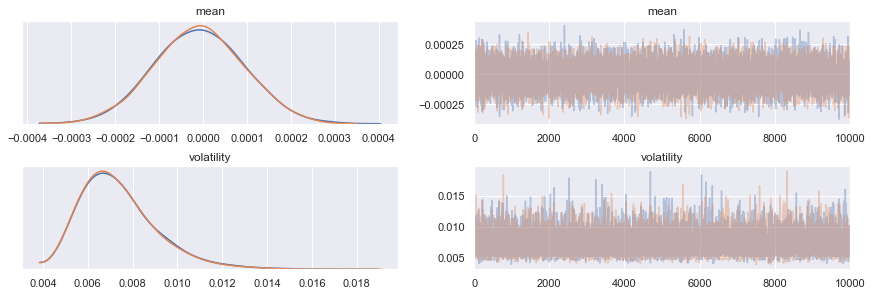

In [18]:
_ = az.plot_trace(trace)

No obvious anomalies can be seen by visual inspection. We now compute the summary statistics for the inference (aggregating the draws from each train).

In [19]:
az.summary(trace, round_to=9)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
mean,-0.000009,0.000102,0.000001,-0.000201,0.000183,20191.0,1.0
volatility,0.007363,0.001705,0.000016,0.004614,0.010505,15261.0,1.0


Both values of the Gelman-Rubin statistic (`r_hat`) are 1 and that the effective number of draws for each marginal parameter distribution (`eff_n`) are > 10,000. Thus, we have confidence that the MCMC algorithm has successfully inferred (or explored) the posterior distribution for our chosen probabilistic program. We now take a closer look at the marginal parameter distributions.

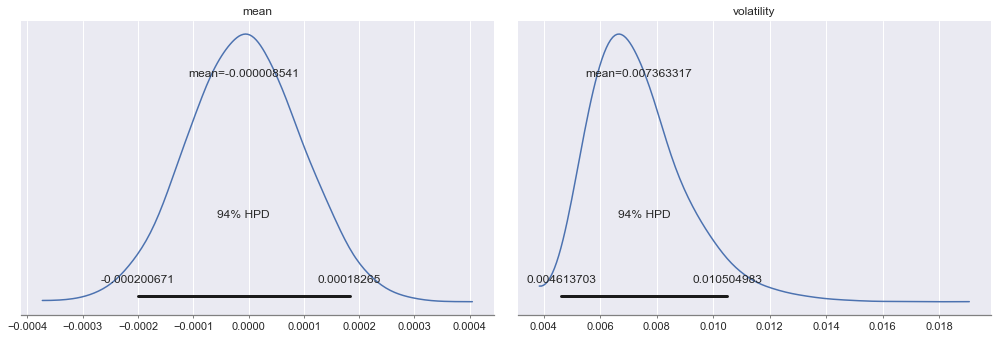

In [20]:
_ = az.plot_posterior(trace, round_to=9)

And their dependency structure.

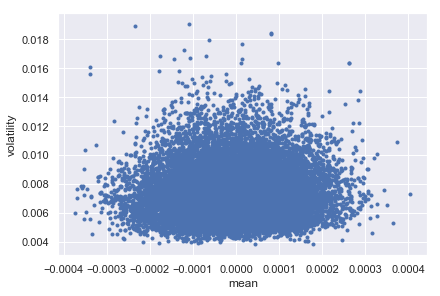

In [21]:
_ = az.plot_pair(trace)

Finally, we compute estimates for $\mu$ and $\sigma$, based on our Bayesian point-estimates.

In [22]:
dist_mean_bayes = trace.get_values('mean').mean()
dist_sd_bayes = trace.get_values('volatility').mean()

sigma_bayes = dist_sd_bayes * np.sqrt(365)
mu_bayes = dist_mean_bayes / 365 + 0.5 * dist_sd_bayes ** 2

print(f'bayesian estimate of mu = {mu_bayes:.5f}')
print(f'bayesian estimate of sigma = {sigma_bayes:.4f}')

bayesian estimate of mu = 0.00003
bayesian estimate of sigma = 0.1407


The estimate for $\mu$ is far better than both ML estimates (full and partial data) and the estimate for $\sigma$ is considerably better than the ML estimate with partial data and approaching that with full data.

## Making Predictions

Perhaps most importantly, how do the differences in parameter inference methodology translate into predictions for future distributions of geometric returns? We compare a (Normal) distribution of daily geometric returns simulated using the constant empirical parameter estimates with partial data (black line in the plot below), to that simulated by using random draws of Bayesian parameter estimates from the marginal posterior distributions (red line in the plot below).

100%|██████████| 10000/10000 [00:05<00:00, 1788.40it/s]


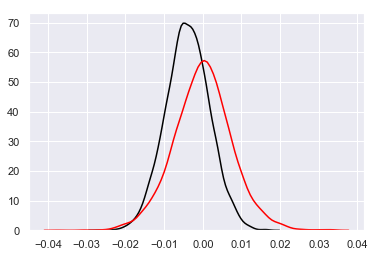

In [23]:
n_samples=10000
np.random.seed(42)

posterior_predictive_samples = pm.sampling.sample_ppc(
    trace, samples=n_samples, model=model_gbm, random_seed=42)

returns_geo_bayes = posterior_predictive_samples['daily_returns'][:, 1]
returns_geo_ml = np.random.normal(dist_mean_ml, dist_vol_ml, n_samples)

_ = sns.distplot(returns_geo_ml, hist=False, color='black')
_ = sns.distplot(returns_geo_bayes, hist=False, color='red')

We can clearly see that taking a Bayesian Inference approach to calibrating stochastic processes leads to more probability mass in the 'tails' of the distribution of geomtric returns.

### Impact on Risk Metrics - Value-at-Risk (VaR)

We now quantify the impact that the difference in these distributions has on the VaR for a single unit of the stock, at the 1% and 99% percentile levels - i.e. on 1/100 chance events.

In [24]:
var_ml = np.percentile(returns_geo_ml, [1, 99])
var_bayes = np.percentile(returns_geo_bayes, [1, 99])

print(f'VaR-1%:')
print('-------')
print(f'maximum likelihood = {var_ml[0]}')
print(f'bayesian = {var_bayes[0]}')

print(f'\nVaR-99%:')
print('--------')
print(f'maximum likelihood = {var_ml[1]}')
print(f'bayesian = {var_bayes[1]}')

VaR-1%:
-------
maximum likelihood = -0.017048787051462327
bayesian = -0.01853874227071885

VaR-99%:
--------
maximum likelihood = 0.009175421564332082
bayesian = 0.019038871195300778


We can see that maximum likelihood estimation in our setup would underestimate risk for both long (VaR-1%) and short (VaR-99%) positions, but particularly for short position where the difference is by over 100%.

## Summary

- Bayesian inference can exploit prior knowledge to result in more precise parameter estimate for stochastic processes, especially when data is scarce; and,
- because it doesn't rely on point-estimates of parameters and is intrinsically stochastic in nature, it is a natural unified framework for parameter inference and simulation, under uncertainty.